In [1]:
import sys
sys.path.append('..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import taiko as tk
from taiko.tools.config import *
from taiko.play import get_play, get_similarity
from taiko.database import load_record_df

from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import posixpath
import multiprocessing
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)

Using TensorFlow backend.


In [3]:
SONG_ID = 1

In [4]:
record_df = load_record_df(song_id=SONG_ID)
record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime
1,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05
5,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13
9,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41
13,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23
25,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16
29,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10
33,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26
37,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11
42,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21
46,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57


In [5]:
play_result_df = pd.read_csv(PLAY_RESULT_TABLE_PATH)
play_result_df.drop(['drummer_name', 'song_id', 'capture_datetime'], axis=1, inplace=True)
play_record_df = record_df.merge(play_result_df, left_index=True, right_on='id', how='inner')
play_record_df['note'] = play_record_df['good'] + play_record_df['ok'] + play_record_df['bad']
play_record_df = play_record_df[play_record_df['note'] == ALL_NOTE_COUNT_DICT[SONG_ID]]
play_record_df.drop('note', axis=1, inplace=True)
play_record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
16,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16,25,1,792630,54,30,2,84,42
20,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10,29,2,803450,57,25,4,61,48
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,94
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,95


In [6]:
full_combo_df = play_record_df[play_record_df['bad'] == 0]
full_combo_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,94
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,95
38,celiven,1,L_2018-09-22_144040.csv,R_2018-09-22_144039.csv,capture_2018_09_22_14_40_39,50,3,989460,84,2,0,86,94
40,celiven,1,L_2018-09-22_145139.csv,R_2018-09-22_145139.csv,capture_2018_09_22_14_51_38,54,4,999560,86,0,0,86,50


In [7]:
# test
# CONSIDERED_IDS = [61, 150]

# doraemon individual
# CONSIDERED_IDS = [1, 33, 61, 99, 150, 180, 241, 254, 288, 323]

# doraemon individual for two occurance
CONSIDERED_IDS = [1, 5, 33, 37, 61, 65, 99, 107, 141, 150, 180, 181, 241, 249, 254, 258, 288, 310, 323, 327]

# RPG individual for two occurance
# CONSIDERED_IDS = [10, 14, 52, 56, 79, 83, 121, 125, 155, 159, 208, 216, 280, 284, 311, 315, 350, 354]

# All
# CONSIDERED_IDS = full_combo_df['id'].values

CONSIDERED_IDS

[1,
 5,
 33,
 37,
 61,
 65,
 99,
 107,
 141,
 150,
 180,
 181,
 241,
 249,
 254,
 258,
 288,
 310,
 323,
 327]

In [8]:
plays = []
with multiprocessing.Pool() as p:
    record_rows = [record_df.loc[id_] for id_ in CONSIDERED_IDS]
    for _, play in tqdm(enumerate(p.imap(get_play, record_rows)), total=len(record_rows)):
        try:
            plays.append(play)
        except Exception:
            pass

play_record_df[play_record_df['id'].isin(CONSIDERED_IDS)]

100%|██████████| 20/20 [01:03<00:00,  9.44s/it]


,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
45,chris,1,L_2018-09-26_133059.csv,R_2018-09-26_133100.csv,capture_2018_09_26_13_30_59,61,1,908230,76,10,0,86,44
49,chris,1,L_2018-09-26_134302.csv,R_2018-09-26_134304.csv,capture_2018_09_26_13_43_03,65,2,987660,85,1,0,86,50
81,cuxi,1,L_2018-09-25_160510.csv,R_2018-09-25_160512.csv,capture_2018_09_25_16_05_13,99,2,942410,77,9,0,86,63
89,cuxi,1,L_2018-09-25_163116.csv,R_2018-09-25_163117.csv,capture_2018_09_25_16_31_18,107,4,974110,81,5,0,86,67
121,eve,1,L_2018-09-26_175516.csv,R_2018-09-26_175517.csv,capture_2018_09_26_17_55_17,141,4,892060,67,19,0,86,39
129,eve,1,L_2018-09-28_163325.csv,R_2018-09-28_163326.csv,capture_2018_09_28_16_33_26,150,6,928410,75,11,0,86,38


In [9]:
HANDS = ['L', 'R']
_K = 370
SIMILARITY_COLUMNS = [a + '_' + b for a, b in product(HANDS, ZERO_ADJ_COL)]
SIMILARITY_COLUMNS = [str(k) + '_' + b for k, b in product(range(_K), SIMILARITY_COLUMNS)]
SIMILARITY_COLUMNS

['0_L_imu_ax',
 '0_L_imu_ay',
 '0_L_imu_az',
 '0_L_imu_gx',
 '0_L_imu_gy',
 '0_L_imu_gz',
 '0_R_imu_ax',
 '0_R_imu_ay',
 '0_R_imu_az',
 '0_R_imu_gx',
 '0_R_imu_gy',
 '0_R_imu_gz',
 '1_L_imu_ax',
 '1_L_imu_ay',
 '1_L_imu_az',
 '1_L_imu_gx',
 '1_L_imu_gy',
 '1_L_imu_gz',
 '1_R_imu_ax',
 '1_R_imu_ay',
 '1_R_imu_az',
 '1_R_imu_gx',
 '1_R_imu_gy',
 '1_R_imu_gz',
 '2_L_imu_ax',
 '2_L_imu_ay',
 '2_L_imu_az',
 '2_L_imu_gx',
 '2_L_imu_gy',
 '2_L_imu_gz',
 '2_R_imu_ax',
 '2_R_imu_ay',
 '2_R_imu_az',
 '2_R_imu_gx',
 '2_R_imu_gy',
 '2_R_imu_gz',
 '3_L_imu_ax',
 '3_L_imu_ay',
 '3_L_imu_az',
 '3_L_imu_gx',
 '3_L_imu_gy',
 '3_L_imu_gz',
 '3_R_imu_ax',
 '3_R_imu_ay',
 '3_R_imu_az',
 '3_R_imu_gx',
 '3_R_imu_gy',
 '3_R_imu_gz',
 '4_L_imu_ax',
 '4_L_imu_ay',
 '4_L_imu_az',
 '4_L_imu_gx',
 '4_L_imu_gy',
 '4_L_imu_gz',
 '4_R_imu_ax',
 '4_R_imu_ay',
 '4_R_imu_az',
 '4_R_imu_gx',
 '4_R_imu_gy',
 '4_R_imu_gz',
 '5_L_imu_ax',
 '5_L_imu_ay',
 '5_L_imu_az',
 '5_L_imu_gx',
 '5_L_imu_gy',
 '5_L_imu_gz',
 '5_R_imu_

In [10]:
similarity_mat = []
with multiprocessing.Pool() as p:
    result = p.starmap(get_similarity, product(plays, repeat=2))
    ids = list(product(CONSIDERED_IDS, repeat=2))
    for ids_, sim in zip(ids, result):
        similarity_mat.append(list(ids_) + list(sim))
#         sim = get_similarity(row1[1], row2[1])
#         similarity_mat.append([row1[0], row2[0], sim[0], sim[1]])
#         print(sim)

similarity_df = pd.DataFrame(data=similarity_mat)
similarity_df.columns = ['a_id', 'b_id'] + SIMILARITY_COLUMNS
similarity_df

,a_id,b_id,0_L_imu_ax,0_L_imu_ay,0_L_imu_az,0_L_imu_gx,0_L_imu_gy,0_L_imu_gz,0_R_imu_ax,0_R_imu_ay,...,369_L_imu_az,369_L_imu_gx,369_L_imu_gy,369_L_imu_gz,369_R_imu_ax,369_R_imu_ay,369_R_imu_az,369_R_imu_gx,369_R_imu_gy,369_R_imu_gz
0,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,5,2.924983,5.572706,3.737061,63.204431,110.386542,28.642757,2.815819,6.105488,...,17.669147,10.478993,28.308160,32.288409,1.201969,4.820462,17.188714,20.162659,50.605301,33.023976
2,1,33,10.169589,11.184191,4.777461,124.699450,161.459841,96.109019,3.205315,12.089189,...,17.897770,17.998164,32.330166,27.927642,1.387638,8.263089,18.442148,15.603448,78.247844,32.000161
3,1,37,3.283723,3.698440,2.809924,59.195087,107.441009,30.786548,2.771017,4.033552,...,22.500267,27.854075,24.070765,27.338992,1.427862,2.904193,22.222839,30.104379,49.327347,20.819719
4,1,61,3.491989,7.699344,10.632944,113.045052,122.863664,48.242037,3.191351,1.427246,...,21.513673,64.766903,65.440517,74.381256,3.069283,2.467802,21.354689,40.353078,59.816095,54.803634
5,1,65,5.321567,5.623460,10.784816,33.142017,141.472906,62.128766,2.146864,2.670773,...,27.929825,201.680662,18.760441,70.062614,2.597475,20.030901,28.207157,116.796938,27.635071,52.160896
6,1,99,5.522518,8.024690,4.544273,131.437856,103.411914,32.025740,9.149560,5.691698,...,63.539540,133.074662,34.853633,34.491937,7.612598,18.558740,62.594280,122.454367,41.438765,65.092255
7,1,107,4.636138,7.235649,4.798611,81.469163,109.347301,30.442159,3.798343,6.419698,...,55.499479,92.407695,29.363146,14.685990,2.711424,11.824592,54.819254,88.399067,31.835526,25.731877
8,1,141,2.761603,9.440409,9.205768,43.200021,123.926802,59.294089,3.660469,8.753368,...,25.433758,74.182371,81.913848,263.783019,4.125574,26.858674,24.711214,172.770169,126.976513,173.944610
9,1,150,10.527203,14.191264,6.924996,295.387051,141.422106,593.959389,10.590508,34.315195,...,23.429299,19.080087,28.867267,16.566838,1.787197,5.841005,23.205719,23.886775,44.463547,43.211122


In [11]:
dtw_df = similarity_df.copy()
dtw_df['same'] = (dtw_df['a_id'] == dtw_df['b_id'])
dtw_df = dtw_df[~dtw_df['same']].drop('same', axis=1)
# for col in SIMILARITY_COLUMNS:
#     sns.distplot(dtw_df[col])
#     plt.show()

In [12]:
scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
# dtw_df['acc_dtw'] -= dtw_df.min(axis=0)['acc_dtw']
# dtw_df['gyr_dtw'] -= dtw_df.min(axis=0)['gyr_dtw']
dtw_df['norm_sim'] = dtw_df[SIMILARITY_COLUMNS].mean(axis=1)
dtw_df

,a_id,b_id,0_L_imu_ax,0_L_imu_ay,0_L_imu_az,0_L_imu_gx,0_L_imu_gy,0_L_imu_gz,0_R_imu_ax,0_R_imu_ay,...,369_L_imu_gx,369_L_imu_gy,369_L_imu_gz,369_R_imu_ax,369_R_imu_ay,369_R_imu_az,369_R_imu_gx,369_R_imu_gy,369_R_imu_gz,norm_sim
1,1,5,-0.855559,-0.646012,-0.813240,-0.557605,0.792122,-0.598964,-0.814489,-0.585872,...,-1.195113,-1.073446,-0.809642,-1.273530,-1.103478,0.178543,-1.023275,-0.825209,-1.010901,0.036697
2,1,33,1.913802,-0.050641,-0.444901,0.179612,2.236105,-0.184340,-0.685446,-0.049383,...,-1.082917,-0.966165,-0.871198,-1.232734,-0.756147,0.279086,-1.053203,-0.380560,-1.022778,-0.067233
3,1,37,-0.718425,-0.844870,-1.141479,-0.605670,0.708844,-0.585789,-0.829333,-0.771638,...,-0.935855,-1.186472,-0.879507,-1.223896,-1.296813,0.582351,-0.958014,-0.845766,-1.152479,-0.083250
4,1,61,-0.638813,-0.420379,1.628149,0.039896,1.144885,-0.478514,-0.690072,-1.005315,...,-0.385071,-0.082998,-0.215465,-0.863235,-1.340841,0.512713,-0.890737,-0.677047,-0.758242,-0.086632
5,1,65,0.060571,-0.640627,1.681917,-0.918000,1.671019,-0.393171,-1.036121,-0.893823,...,1.657848,-1.328117,-0.276426,-0.966903,0.431122,1.062378,-0.388932,-1.194701,-0.788900,-0.142175
6,1,99,0.137388,-0.385860,-0.527458,0.260393,0.594930,-0.578174,1.283939,-0.622972,...,0.634163,-0.898856,-0.778537,0.135043,0.282594,3.820710,-0.351795,-0.972659,-0.638887,0.059562
7,1,107,-0.201444,-0.469576,-0.437413,-0.338643,0.762740,-0.587906,-0.488970,-0.557700,...,0.027363,-1.045306,-1.058115,-0.941866,-0.396823,3.197043,-0.575346,-1.127134,-1.095494,0.184586
8,1,141,-0.918014,-0.235654,1.122878,-0.797422,1.174943,-0.410592,-0.534649,-0.348467,...,-0.244581,0.356403,2.458104,-0.631142,1.119984,0.781954,-0.021504,0.403273,0.623875,0.063896
9,1,150,2.050505,0.268406,0.315403,2.225854,1.669583,2.875276,1.761338,1.943365,...,-1.066774,-1.058533,-1.031565,-1.144941,-1.000515,0.661192,-0.998828,-0.924003,-0.892723,0.035543
10,1,180,0.091898,-0.686150,-0.876280,-0.539739,0.465057,-0.674316,-0.063188,-0.618825,...,-0.787664,0.132944,0.168673,1.336628,0.780649,1.245307,1.843307,2.120027,1.935409,0.610318


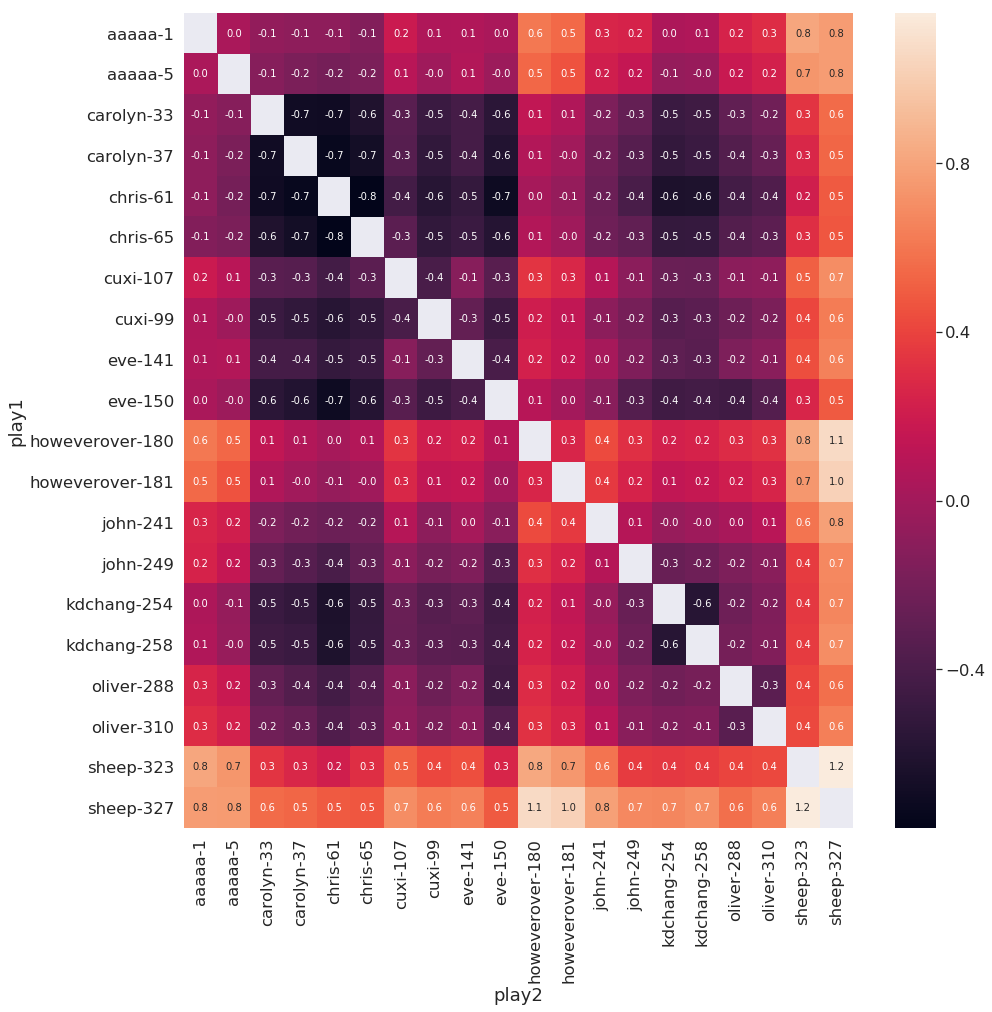

In [13]:
vis_right_df = play_record_df.copy()
vis_right_df = vis_right_df[['drummer_name', 'id']]

vis_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
vis_df = vis_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
vis_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
vis_df = vis_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                  'drummer_name_y': 'b_drummer_name'})
vis_df['a_id'] = vis_df['a_id'].apply(str)
vis_df['b_id'] = vis_df['b_id'].apply(str)
vis_df['play1'] = vis_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df['play2'] = vis_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df = vis_df.pivot('play1', 'play2', 'norm_sim')
plt.figure(figsize=(15, 15))
ax = sns.heatmap(vis_df, annot=True, fmt='.1f')

# LGBM

In [14]:
import lightgbm as lgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

In [15]:
score_right_df = play_record_df.copy()
score_right_df = score_right_df[['score', 'id']]

score_df = dtw_df.copy()
score_df = score_df.merge(score_right_df, left_on='a_id', right_on='id', how='inner')
score_df = score_df.merge(score_right_df, left_on='b_id', right_on='id', how='inner')
score_df = score_df[score_df['a_id'] < score_df['b_id']].reset_index(drop=True)
score_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
score_df['score_dif'] = np.abs(score_df['score_x'] - score_df['score_y'])
score_df.drop(['score_x', 'score_y'], axis=1, inplace=True)
score_df

,a_id,b_id,0_L_imu_ax,0_L_imu_ay,0_L_imu_az,0_L_imu_gx,0_L_imu_gy,0_L_imu_gz,0_R_imu_ax,0_R_imu_ay,...,369_L_imu_gy,369_L_imu_gz,369_R_imu_ax,369_R_imu_ay,369_R_imu_az,369_R_imu_gx,369_R_imu_gy,369_R_imu_gz,norm_sim,score_dif
0,1,5,-0.855559,-0.646012,-0.813240,-0.557605,0.792122,-0.598964,-0.814489,-0.585872,...,-1.073446,-0.809642,-1.273530,-1.103478,0.178543,-1.023275,-0.825209,-1.010901,0.036697,14250
1,1,33,1.913802,-0.050641,-0.444901,0.179612,2.236105,-0.184340,-0.685446,-0.049383,...,-0.966165,-0.871198,-1.232734,-0.756147,0.279086,-1.053203,-0.380560,-1.022778,-0.067233,29550
2,5,33,1.353815,0.515919,-0.381661,-0.480112,0.024193,-0.092980,-1.402097,0.489249,...,-1.249406,-0.555666,-1.256698,-0.309201,-1.102796,-0.978618,-0.999440,-0.703408,-0.121870,43800
3,1,37,-0.718425,-0.844870,-1.141479,-0.605670,0.708844,-0.585789,-0.829333,-0.771638,...,-1.186472,-0.879507,-1.223896,-1.296813,0.582351,-0.958014,-0.845766,-1.152479,-0.083250,61150
4,5,37,-1.668795,-1.035340,-1.729437,-1.256047,-2.123256,-0.750243,-1.443098,-0.945592,...,-1.419288,-0.750266,-1.226510,-0.846550,-0.815760,-0.926515,-1.291859,-0.982639,-0.168724,75400
5,33,37,1.303622,0.322169,-0.563889,-0.447961,0.018177,-0.090993,-1.242986,0.302342,...,-1.528798,-0.709502,-1.309358,-1.040802,-0.895170,-1.050049,-1.161276,-0.992725,-0.690682,31600
6,1,61,-0.638813,-0.420379,1.628149,0.039896,1.144885,-0.478514,-0.690072,-1.005315,...,-0.082998,-0.215465,-0.863235,-1.340841,0.512713,-0.890737,-0.677047,-0.758242,-0.086632,66880
7,5,61,-1.518852,-0.821102,0.418400,-0.437150,-1.373907,-0.331805,-1.165052,-0.688870,...,-0.294734,0.016692,-0.907382,-1.082435,-0.872596,-0.796995,-0.700482,-0.434335,-0.198135,81130
8,33,61,1.222125,0.620475,1.436090,-0.701713,-0.066702,-0.260945,-0.996687,0.049302,...,0.065914,-0.165650,-0.722982,-0.737735,-0.957513,-0.979933,-0.462909,-0.750390,-0.699776,37330
9,37,61,-1.657404,-0.727581,0.797845,-0.432001,-1.310615,-0.321068,-1.423396,-0.873211,...,-0.103743,0.105459,-0.768161,-1.252312,-1.106849,-1.010454,-0.684011,-0.664271,-0.739258,5730


In [16]:
train_df = score_df.drop(['a_id', 'b_id', 'norm_sim'], axis=1).copy()
x = train_df.drop('score_dif', axis=1)
y = train_df['score_dif']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=0, test_size=0.5)

train_df

,0_L_imu_ax,0_L_imu_ay,0_L_imu_az,0_L_imu_gx,0_L_imu_gy,0_L_imu_gz,0_R_imu_ax,0_R_imu_ay,0_R_imu_az,0_R_imu_gx,...,369_L_imu_gx,369_L_imu_gy,369_L_imu_gz,369_R_imu_ax,369_R_imu_ay,369_R_imu_az,369_R_imu_gx,369_R_imu_gy,369_R_imu_gz,score_dif
0,-0.855559,-0.646012,-0.813240,-0.557605,0.792122,-0.598964,-0.814489,-0.585872,-0.962012,-0.810434,...,-1.195113,-1.073446,-0.809642,-1.273530,-1.103478,0.178543,-1.023275,-0.825209,-1.010901,14250
1,1.913802,-0.050641,-0.444901,0.179612,2.236105,-0.184340,-0.685446,-0.049383,-0.592719,-0.697760,...,-1.082917,-0.966165,-0.871198,-1.232734,-0.756147,0.279086,-1.053203,-0.380560,-1.022778,29550
2,1.353815,0.515919,-0.381661,-0.480112,0.024193,-0.092980,-1.402097,0.489249,-0.270102,-0.730845,...,-1.026266,-1.249406,-0.555666,-1.256698,-0.309201,-1.102796,-0.978618,-0.999440,-0.703408,43800
3,-0.718425,-0.844870,-1.141479,-0.605670,0.708844,-0.585789,-0.829333,-0.771638,-1.092216,-0.809109,...,-0.935855,-1.186472,-0.879507,-1.223896,-1.296813,0.582351,-0.958014,-0.845766,-1.152479,61150
4,-1.668795,-1.035340,-1.729437,-1.256047,-2.123256,-0.750243,-1.443098,-0.945592,-1.358921,-0.988346,...,-0.896394,-1.419288,-0.750266,-1.226510,-0.846550,-0.815760,-0.926515,-1.291859,-0.982639,75400
5,1.303622,0.322169,-0.563889,-0.447961,0.018177,-0.090993,-1.242986,0.302342,-0.503594,-0.730092,...,-1.198889,-1.528798,-0.709502,-1.309358,-1.040802,-0.895170,-1.050049,-1.161276,-0.992725,31600
6,-0.638813,-0.420379,1.628149,0.039896,1.144885,-0.478514,-0.690072,-1.005315,0.452531,-0.651186,...,-0.385071,-0.082998,-0.215465,-0.863235,-1.340841,0.512713,-0.890737,-0.677047,-0.758242,66880
7,-1.518852,-0.821102,0.418400,-0.437150,-1.373907,-0.331805,-1.165052,-0.688870,-0.011313,-0.653167,...,-0.391966,-0.294734,0.016692,-0.907382,-1.082435,-0.872596,-0.796995,-0.700482,-0.434335,81130
8,1.222125,0.620475,1.436090,-0.701713,-0.066702,-0.260945,-0.996687,0.049302,1.305593,-0.887022,...,-0.542802,0.065914,-0.165650,-0.722982,-0.737735,-0.957513,-0.979933,-0.462909,-0.750390,37330
9,-1.657404,-0.727581,0.797845,-0.432001,-1.310615,-0.321068,-1.423396,-0.873211,0.215195,-0.650010,...,-0.598607,-0.103743,0.105459,-0.768161,-1.252312,-1.106849,-1.010454,-0.684011,-0.664271,5730


In [45]:
train_set = lgb.Dataset(x_train, y_train)
valid_set = lgb.Dataset(x_valid, y_valid, free_raw_data=False)
watchlist = [valid_set]

params = dict({
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'application': 'rmse',
#     'min_data_in_leaf': 3,
#     'max_depth': 5,
#     'num_leaves': 2 ** 5,
    'min_data': 1,
    'verbosity': 0,
#     'metric': 'rmse'
})

grid_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 10],
}

model = lgb.train(params, train_set=train_set, valid_sets=watchlist,
                  num_boost_round=500, verbose_eval=10, early_stopping_rounds=100)
y_pred = model.predict(x_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's rmse: 56530.8
[20]	valid_0's rmse: 51553.9
[30]	valid_0's rmse: 50608.3
[40]	valid_0's rmse: 50385
[50]	valid_0's rmse: 50321.9
[60]	valid_0's rmse: 50288.9
[70]	valid_0's rmse: 50275.2
[80]	valid_0's rmse: 50271.3
[90]	valid_0's rmse: 50269.9
[100]	valid_0's rmse: 50269.2
[110]	valid_0's rmse: 50269
[120]	valid_0's rmse: 50268.9
[130]	valid_0's rmse: 50268.9
[140]	valid_0's rmse: 50268.9
[150]	valid_0's rmse: 50268.9
[160]	valid_0's rmse: 50268.9
[170]	valid_0's rmse: 50268.9
[180]	valid_0's rmse: 50268.9
[190]	valid_0's rmse: 50268.9
[200]	valid_0's rmse: 50268.9
[210]	valid_0's rmse: 50268.9
[220]	valid_0's rmse: 50268.9
[230]	valid_0's rmse: 50268.9
[240]	valid_0's rmse: 50268.9
[250]	valid_0's rmse: 50268.9
[260]	valid_0's rmse: 50268.9
[270]	valid_0's rmse: 50268.9
[280]	valid_0's rmse: 50268.9
[290]	valid_0's rmse: 50268.9
[300]	valid_0's rmse: 50268.9
[310]	valid_0's rmse: 50268.9
[320]	valid_0's rmse

In [46]:
y_pred

array([ 41897.93971795,  93220.18421723,  33747.46601965, 183873.48494804,
        23556.89574168,  60439.59570911,  22297.38223838,  27998.69261062,
        19785.45781484,  76806.45691946,  31989.1618336 ,  23163.00493307,
        32273.59616086,  39187.62151027, 155891.30576383,  67221.02948037,
        40579.66040741, 121704.7488107 ,  35200.12934753,  17421.91245242,
        10654.18499132, 147665.53765942, 162495.88928765,  34686.4744131 ,
        17425.15594807, 157836.77243713,  34622.50864825,  30138.21994685,
        25432.78718022,  65842.23673145,  57038.14486541,  18072.13376611,
       157836.77243737,  51717.52194168,  21714.91846238,  41796.40871303,
        67066.31312963,  34610.18015238])

In [44]:
y_test

108       400
74      40100
161     70450
95     234240
123     32500
71     135700
18      28450
124     38230
143     91010
7       81130
5       31600
187     36750
156     48550
168     48150
185    309220
113     22300
37      60950
66     123150
136     92010
131     15750
56      27150
101    304070
134    272470
180     54800
170     79410
150    209110
63      70150
60      25450
116     47850
33      95600
4       75400
55      12900
94     239970
44      36350
45       2950
26      13550
176      4450
138     62460
Name: score_dif, dtype: int64

In [47]:
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 53478.89769447919
